# Краткое описание датасета
Датасет представляет собой набор данных о различных видах рыб из реки Тетулия в Индии.

### Атрибуты
Имеются следующие атрибуты:
- species - название вида рыбы
- length - длинна в см
- weight - вес в граммах
- w_l_ratio - вес/длинна

### Источик данных и характер данных
Датасет взят из: https://www.kaggle.com/datasets/taweilo/fish-species-sampling-weight-and-height-data?select=fish_data.csv. Данные имитационные

### Описание задачи анализа
Классификация: предсказать класс рыбы, используя представленные атрибуты.

# Первичная работа

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load data
data = pd.read_csv('../dataset/fish_data.csv')

In [3]:
data.head()

,species,length,weight,w_l_ratio
0,Anabas testudineus,10.66,3.45,0.32
1,Anabas testudineus,6.91,3.27,0.47
2,Anabas testudineus,8.38,3.46,0.41
3,Anabas testudineus,7.57,3.36,0.44
4,Anabas testudineus,10.83,3.38,0.31


In [4]:
data.shape

(4080, 4)

#### Отчистка

In [5]:
# red
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4080 entries, 0 to 4079
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   species    4080 non-null   object 
 1   length     4080 non-null   float64
 2   weight     4080 non-null   float64
 3   w_l_ratio  4080 non-null   float64
dtypes: float64(3), object(1)
memory usage: 127.6+ KB


In [6]:
data.isnull().sum()

species      0
length       0
weight       0
w_l_ratio    0
dtype: int64

In [7]:
# удаляем выбросы
data = data[np.abs(data['length']-data['length'].mean()) <= (3*data['length'].std())]
data = data[np.abs(data['weight']-data['weight'].mean()) <= (3*data['weight'].std())]
data = data[np.abs(data['w_l_ratio']-data['w_l_ratio'].mean()) <= (3*data['w_l_ratio'].std())]
# удаляем дубли и NaN
data = data.drop_duplicates().dropna()
data.shape

(3967, 4)

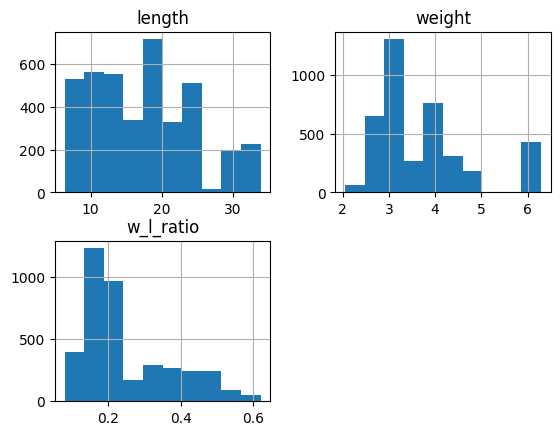

In [8]:
fig = data.hist()

# Классификация

### Метка класса
В роли целевого атрибута (метки класса) выступит атрибут species - т.к. это номинальный атрибут.

### Сбалансированность классов

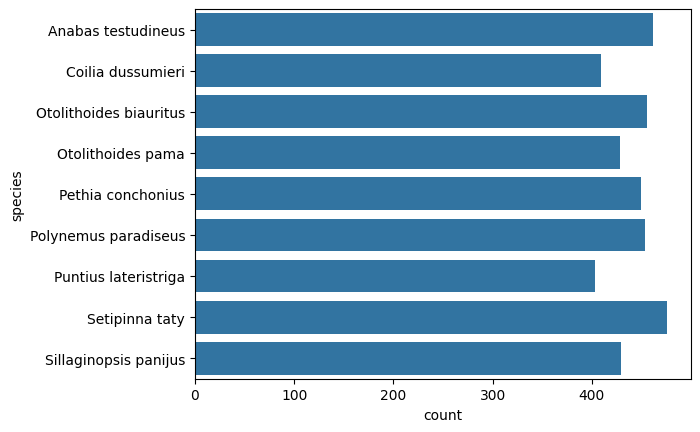

In [9]:
fig = sns.countplot(data['species'])

В целом классы довольно сбалансированные и в ребалансировке необходимости нет

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn .tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_curve, auc

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

In [11]:
X = data[['length', 'weight', 'w_l_ratio']]
y = data[['species']]

le = LabelEncoder()
y = le.fit_transform(y)

ss = StandardScaler()
X = ss.fit_transform(X)

In [12]:
X_tr, X_t, y_tr, y_t = train_test_split(X, y, test_size=0.3, stratify=y)

## KNN

Определяем оптимальный параметр k и остальные настройки модели

In [13]:
grid_params = { 'n_neighbors': [i for i in range(1, 25)],
	'weights': ['uniform','distance'],
	'metric': ['minkowski', 'euclidean', 'manhattan'],
}

In [14]:
knn = KNeighborsClassifier()
gs = GridSearchCV(knn, grid_params, scoring='accuracy', refit=True)

gs_res = gs.fit(X_tr, y_tr)
print(gs_res.best_params_)

{'metric': 'minkowski', 'n_neighbors': 13, 'weights': 'uniform'}


Сама классификация

In [15]:
p_val = 2 # minkowski default is 2
if gs_res.best_params_['metric'] == 'manhattan':
    p_val = 1

knn = KNeighborsClassifier(
    n_neighbors=gs_res.best_params_['n_neighbors'], 
    p=p_val,
    weights=gs_res.best_params_['weights'],
)
knn.fit(X_tr, y_tr)
knn_predicted = knn.predict(X_t)

In [16]:
# accuracy
actual = y_t

count_right = 0
count_wrong = 0
for i in range(len(actual)):
    if actual[i] == knn_predicted[i]:
        count_right += 1
    else:
        count_wrong += 1

acc = count_right / (count_right + count_wrong)
print(acc)

0.9361880772460117


#### Accuracy ~ 93.6%

Precision, recall, F-measure

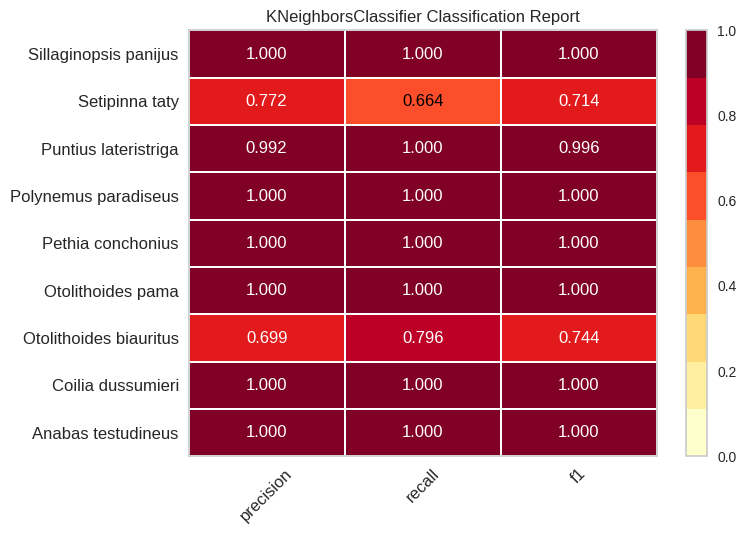

In [17]:
visualizer = ClassificationReport(knn, classes=le.classes_)
visualizer.fit(X_tr, y_tr)
visualizer.score(X_t, y_t)
fig = visualizer.show()

ROC-curve

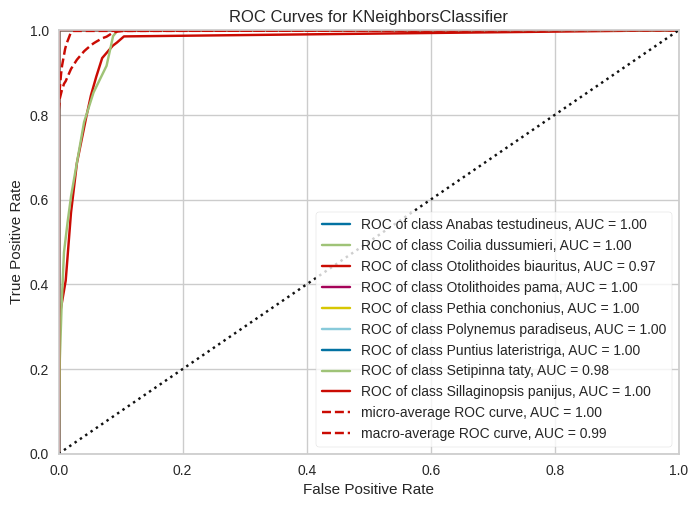

In [18]:
visualizer = ROCAUC(knn, classes=le.classes_)

visualizer.fit(X_tr, y_tr)
visualizer.score(X_t, y_t)
fig = visualizer.show()    

AUC > 0.9 для всех классов - получили отличное качество классификации

## Дерево решений

In [19]:
dt = DecisionTreeClassifier()
dt.fit(X_tr, y_tr)
dt_predicted = dt.predict(X_t)

In [20]:
# accuracy
actual = y_t

count_right = 0
count_wrong = 0
for i in range(len(actual)):
    if actual[i] == dt_predicted[i]:
        count_right += 1
    else:
        count_wrong += 1

acc = count_right / (count_right + count_wrong)
print(acc)

0.9311502938706969


#### Accuracy ~ 93.1%

Precision, recall, F-measure

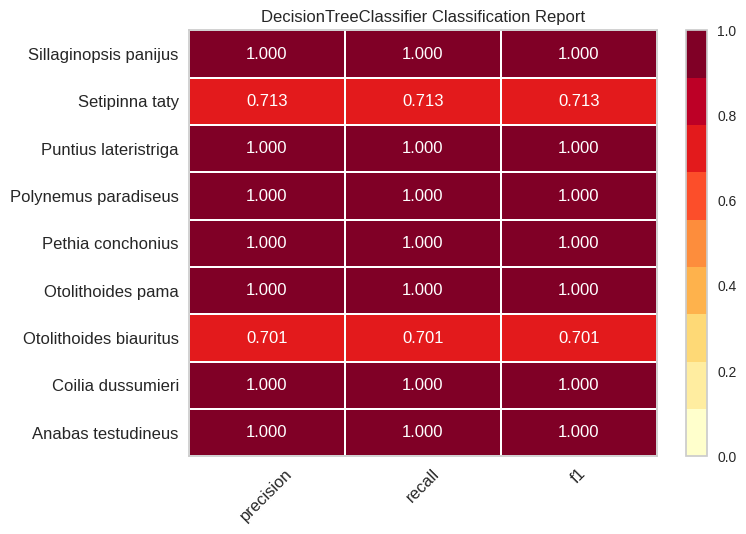

In [21]:
visualizer = ClassificationReport(dt, classes=le.classes_)
visualizer.fit(X_tr, y_tr)
visualizer.score(X_t, y_t)
fig = visualizer.show()

ROC-curve

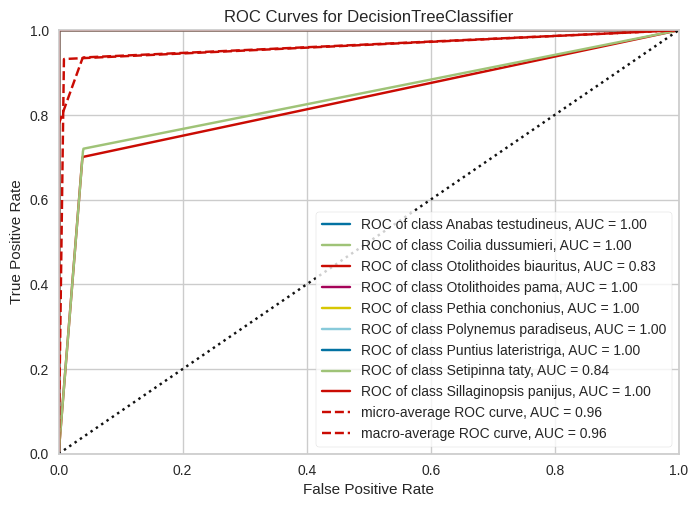

In [22]:
visualizer = ROCAUC(dt, classes=le.classes_)

visualizer.fit(X_tr, y_tr)
visualizer.score(X_t, y_t)
fig = visualizer.show()  

AUC > 0.8 для всех классов - получили очень хорошее качество классификации

Причем, очень хорошее качество классификации только у двух классов - у остальных отличное

# Выводы

Вообщем то, оба классификатора показали себя очень хорошо на выбранном датасете. Классификатор дерево решений уступает классификатору KNN в качестве классификации и акуратности, recall, precision и f-мера у него тоже хуже, но, как мне кажется, незначительно.

Можно сделать предположение, что из-за особенности данных (все числовые, очень похожие значения) KNN в целом должен быть всегда лучше, поскольку decision-tree будет сложнее сделать тот самый decision на каждом шаге - данные довольно похожи.